In [1]:
import numpy as np
import numpy.linalg as la
import os
from ctypes import c_int, c_double, POINTER, cdll
from tqdm import tqdm

import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'grid'])
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize': (8, 6)})

In [2]:
# Release dll if loaded
dll = None
# Compile cuda code and load dll
os.system("pwsh ./run.ps1 > log")
dll = cdll.LoadLibrary("./build/Release/kernel.dll")
## Define function signatures
# # void call_qpe_kernel(double* data, int nAll, int T, int R, bool unbiased)
# dll.call_qpe_kernel.argtypes = [POINTER(c_double), c_int, c_int, c_int, c_int]
# # void call_oqae_kernel(double* data, int nAll, int T)
# dll.call_oqae_kernel.argtypes = [POINTER(c_double), c_int, c_int]
# void call_mlae_kernel(double* data, int nAll, int length, int* Ms, int* Rs, double eta, int precision)
dll.call_mlae_kernel.argtypes = [POINTER(c_double), c_int, c_int, POINTER(c_int), POINTER(c_int), c_double, c_int]
# void call_rqae_kernel(double* data, int nAll, int length, int* Ms, double eta, int precision)
dll.call_rqae_kernel.argtypes = [POINTER(c_double), c_int, c_int, POINTER(c_int), c_double, c_int]

In [3]:
nSample = 4000
stats = {}
for R0 in [12, 16, 20, 24]:
    stat_RQAE = []
    for D in 1<<np.arange(3, 10):
        src = np.random.random(nSample)
        res = np.copy(src)
        cdf = np.cumsum(1 / np.arange(1, D+1))
        length = round(R0 * cdf[-1])
        cdf /= cdf[-1]  # normalize to 1
        # sample cdf for length points
        Ms = np.array([np.searchsorted(cdf, np.random.random()) + 1 for i in range(length)], dtype=np.int32)
        # print(f'T = {T}, Ms = {Ms}')
        dll.call_rqae_kernel(res.ctypes.data_as(POINTER(c_double)), nSample, length, Ms.ctypes.data_as(POINTER(c_int)), 1.0, 4000)
        cost = Ms.sum()
        err = la.norm(res - src) / np.sqrt(nSample)
        stat_RQAE.append([cost, err])
        print(f'R0 = {R0},\tD = {D},\tcost = {cost},\terr = {err},\tFactor = {cost * err}')
    stats[f'$R_0$ = {R0}'] = stat_RQAE

R0 = 12,	D = 8,	cost = 103,	err = 0.022582337403545732,	Factor = 2.3259807525652105
R0 = 12,	D = 16,	cost = 242,	err = 0.010523591116915918,	Factor = 2.5467090502936522
R0 = 12,	D = 32,	cost = 560,	err = 0.010177456793738108,	Factor = 5.69937580449334
R0 = 12,	D = 64,	cost = 678,	err = 0.006773337492045262,	Factor = 4.592322819606688
R0 = 12,	D = 128,	cost = 955,	err = 0.002923829112267488,	Factor = 2.792256802215451
R0 = 12,	D = 256,	cost = 3026,	err = 0.002364707946074636,	Factor = 7.155606244821849
R0 = 12,	D = 512,	cost = 7970,	err = 0.0004914020580788718,	Factor = 3.9164744028886087
R0 = 16,	D = 8,	cost = 119,	err = 0.021616384778496436,	Factor = 2.572349788641076
R0 = 16,	D = 16,	cost = 269,	err = 0.009981402038235684,	Factor = 2.684997148285399
R0 = 16,	D = 32,	cost = 421,	err = 0.00683529347756134,	Factor = 2.8776585540533244
R0 = 16,	D = 64,	cost = 960,	err = 0.0029638693797959807,	Factor = 2.8453146046041415
R0 = 16,	D = 128,	cost = 2050,	err = 0.0013816223327383819,	Factor =

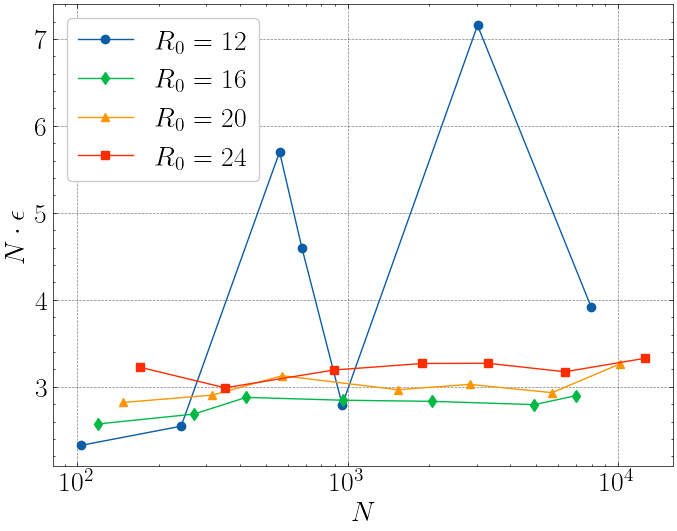

In [4]:
for idx, key in enumerate(stats):
    D, err = np.array(stats[key]).T
    plt.plot(D, D*err, label=key, marker="od^s+h"[idx])
plt.xscale("log")
plt.xlabel("$N$")
plt.ylabel("$N \\cdot \\epsilon$")
plt.grid(True)
plt.legend()
plt.savefig("rqae_params.pdf")
plt.show()